# **Análisis de Databases para el proyecto de Bioimpedancia e IC**
### Utilizando Datos de NHANES y una Balanza de Bioimpedancia Comercial
---
**Curso:** Introducción a las Señales Biomédicas (ISB)

**Fecha:** 02/09/2025
**Utilizando la metodología CRISP-DM:** 1, 2 y 3 - Entendimiento, Comprensión y Preparación de los Datos.

**Objetivo de este Notebook:**
1.  Cargar y fusionar los conjuntos de datos de Antropometría (`BMX_C`), Bioimpedancia (`BIX_C`) y Demográficos (`DEMO_C`) de la encuesta NHANES 2003-2004.
2.  Limpiar los datos y realizar la ingeniería de características necesaria, incluyendo la corrección de unidades y el cálculo de Resistencia y Reactancia.
3.  **Crear una variable objetivo (target)** sustituta para la sobrecarga hídrica, el **Índice de Hidratación (ECW/TBW)**, utilizando ecuaciones de la literatura.
4.  Realizar un Análisis Exploratorio de Datos (EDA) para entender las relaciones entre los predictores y el target.
5.  Evaluar la **viabilidad final** del proyecto, conectando los datos procesados con los datos que se pueden obtener de una balanza Xiaomi Mi Body Composition Scale 2.

In [ ]:
# Para este paso, primero conecto al env que creé para este notebook, con 
# conda activate proyecto_lab2_bioimpedancia
# Ahora necesito instalar las librerías, podría instalar las que necesito en el env y luego tener un yaml 
# ,puedo hacerlas directo desde conda o con pip, en este caso usaré pip
import sys
!{sys.executable} -m pip install --quiet pandas numpy seaborn matplotlib scikit-learn

In [3]:
# Importar las librerías necesarias para el análisis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Configuración de estilo para los gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("Librerías importadas exitosamente.")

Librerías importadas exitosamente.


### Paso 1: Carga y Fusión de los Conjuntos de Datos

Como base de datos referencia, se se utilizó la información disponible en NHANES 2003-2004 a través del portal oficial del CDC <a href="#ref1">[1]</a>.

Cargamos los dos archivos XPT desde sus rutas específicas:
1.  `BMX_C.xpt`: Contiene los datos de mediciones corporales (antropometría).
2.  `BIX_C.xpt`: Contiene los datos de bioimpedancia eléctrica (resistencia y reactancia).

Ambos datasets comparten la columna `SEQN` (Respondent sequence number), que usaremos como clave para fusionarlos en un único DataFrame. Realizamos una unión interna (`inner join`) para trabajar únicamente con los participantes que tienen ambos tipos de datos.

---
<b id="ref1">[1]</b> NHANES 2003-2004 Questionnaires, Datasets, and Related Documentation [Internet]. Cdc.gov. 2010. Available from: https://wwwn.cdc.gov/Nchs/Nhanes/ContinuousNhanes/Default.aspx?BeginYear=2003

In [27]:
# Rutas de los archivos XPT
ruta_base = 'Bioimpedance_databases/'

ruta_bmx = f'{ruta_base}BMX_C.xpt'
ruta_bix = f'{ruta_base}BIX_C.xpt'

try:
    df_bmx = pd.read_sas(ruta_bmx)
    print(f"Dataset de Antropometría (BMX_C) cargado. Dimensiones: {df_bmx.shape}")
    df_bix = pd.read_sas(ruta_bix)
    print(f"Dataset de Bioimpedancia (BIX_C) cargado. Dimensiones: {df_bix.shape}")

    df_merged = pd.merge(df_bmx, df_bix, on='SEQN', how='inner')
    print(f"\nDatasets fusionados (BMX y BIX). Dimensiones: {df_merged.shape}")
except FileNotFoundError as e:
    print(f"Error: {e}. Archivos no encontrados en las rutas especificadas.")

Dataset de Antropometría (BMX_C) cargado. Dimensiones: (9643, 33)
Dataset de Bioimpedancia (BIX_C) cargado. Dimensiones: (5329, 115)

Datasets fusionados (BMX y BIX). Dimensiones: (5329, 147)


### Paso 2: Selección de Variables Clave y Corrección de Unidades

Del dataset fusionado, seleccionamos solo las columnas necesarias para nuestro análisis. Es un paso crucial identificar que, para el ciclo NHANES 2003-2004, las variables de BIE a 50 kHz son `BIXS050K` (Impedancia) y `BIXC050K` (Ángulo de Fase).

**Corrección Importante:** Según la documentación, el Ángulo de Fase (`BIXC050K`) está almacenado como **grados x 100**. Debemos dividirlo entre 100 para obtener el valor correcto en grados.

In [20]:
# Celda de Diagnóstico

# Vamos a listar todas las columnas para confirmar los nombres correctos de las variables
# que se extraerán de Bioimpedancia (BIX según la información del dataset).
bix_columns = [col for col in df_merged.columns if 'BIX' in col]

print("Columnas de Bioimpedancia encontradas en el DataFrame:")
print(bix_columns)

Columnas de Bioimpedancia encontradas en el DataFrame:
['BIXS005K', 'BIXS006K', 'BIXS007K', 'BIXS008K', 'BIXS009K', 'BIXS010K', 'BIXS011K', 'BIXS012K', 'BIXS013K', 'BIXS014K', 'BIXS015K', 'BIXS016K', 'BIXS018K', 'BIXS020K', 'BIXS023K', 'BIXS025K', 'BIXS028K', 'BIXS031K', 'BIXS035K', 'BIXS039K', 'BIXS043K', 'BIXS050K', 'BIXS054K', 'BIXS060K', 'BIXS067K', 'BIXS075K', 'BIXS083K', 'BIXS093K', 'BIXS100K', 'BIXS115K', 'BIXS128K', 'BIXS143K', 'BIXS159K', 'BIXS177K', 'BIXS200K', 'BIXS220K', 'BIXS245K', 'BIXS273K', 'BIXS304K', 'BIXS339K', 'BIXS378K', 'BIXS421K', 'BIXS469K', 'BIXS500K', 'BIXS582K', 'BIXS649K', 'BIXS723K', 'BIXS806K', 'BIXS898K', 'BIXS1M', 'BIXC005K', 'BIXC006K', 'BIXC007K', 'BIXC008K', 'BIXC009K', 'BIXC010K', 'BIXC011K', 'BIXC012K', 'BIXC013K', 'BIXC014K', 'BIXC015K', 'BIXC016K', 'BIXC018K', 'BIXC020K', 'BIXC023K', 'BIXC025K', 'BIXC028K', 'BIXC031K', 'BIXC035K', 'BIXC039K', 'BIXC043K', 'BIXC050K', 'BIXC054K', 'BIXC060K', 'BIXC067K', 'BIXC075K', 'BIXC083K', 'BIXC093K', 'BIXC100K'

In [23]:
# Seleccionar las columnas relevantes con los nombres correctos
columnas_relevantes = [
    'SEQN',      # Identificador
    'BMXWT',     # Peso (kg)
    'BMXHT',     # Altura (cm)
    'BMXBMI',    # Índice de Masa Corporal
    'BIXS050K',  # Impedancia (Z) a 50 kHz
    'BIXC050K'   # Ángulo de Fase (Φ) a 50 kHz
]
df_seleccionado = df_merged[columnas_relevantes].copy()

# Renombramos las columnas para mayor claridad
df_seleccionado.rename(columns={
    'BIXS050K': 'Impedance',
    'BIXC050K': 'PhaseAngle'
}, inplace=True)

# CORRECCIÓN DE UNIDAD DEL ÁNGULO DE FASE (Φ)
# Según la documentación, el ángulo de fase está en centésimas de grado.
# Dividimos entre 100 para obtener el valor en grados
df_seleccionado['PhaseAngle'] = df_seleccionado['PhaseAngle'] / 100

print("Columnas seleccionadas y unidad de Ángulo de Fase corregida.")
display(df_seleccionado.head())

Columnas seleccionadas y unidad de Ángulo de Fase corregida.


,SEQN,BMXWT,BMXHT,BMXBMI,Impedance,PhaseAngle
0,21005.0,137.6,164.5,50.85,NaN,NaN
1,21006.0,55.2,163.0,20.78,NaN,NaN
2,21007.0,47.9,161.2,18.43,652.99,0.7128
3,21008.0,70.0,184.1,20.65,449.80,0.5037
4,21013.0,54.7,159.0,21.64,596.72,0.6472


### Paso 3: Ingeniería de Características y Limpieza Final

Con la Impedancia (Z) y el Ángulo de Fase (Φ) corregidos, ahora podemos calcular la **Resistencia (R)** y la **Reactancia (X)**, que son fundamentales para las ecuaciones de predicción de fluidos corporales.

-   **Resistencia (R)** = Z * cos(Φ)
-   **Reactancia (X)** = Z * sin(Φ)

Posteriormente, eliminamos cualquier fila que tenga datos faltantes en estas columnas clave para asegurar un dataset limpio.

In [28]:
# Convertir el Ángulo de Fase corregido de grados a radianes para los cálculos trigonométricos
phase_angle_rad = np.radians(df_seleccionado['PhaseAngle'])

# Calcular Resistencia (R) y Reactancia (X)
df_seleccionado['Resistance_calc'] = df_seleccionado['Impedance'] * np.cos(phase_angle_rad)
df_seleccionado['Reactance_calc'] = df_seleccionado['Impedance'] * np.sin(phase_angle_rad)

# Revisar los valores nulos antes de la limpieza
print("Valores nulos antes de la limpieza final:")
print(df_seleccionado.isnull().sum())

# Eliminar filas con valores nulos para tener un dataset completo
df_limpio = df_seleccionado.dropna()
print(f"\nDataset limpio. Dimensiones finales: {df_limpio.shape}")

# Verificar que los valores ahora son físicamente posibles (no negativos)
print("\nEstadísticas descriptivas de las variables de BIE calculadas:")
display(df_limpio[['Resistance_calc', 'Reactance_calc', 'PhaseAngle']].describe())

Valores nulos antes de la limpieza final:
SEQN                  0
BMXWT                61
BMXHT                69
BMXBMI               69
Impedance          1031
PhaseAngle         1031
Resistance_calc    1031
Reactance_calc     1031
dtype: int64

Dataset limpio. Dimensiones finales: (4276, 8)

Estadísticas descriptivas de las variables de BIE calculadas:


,Resistance_calc,Reactance_calc,PhaseAngle
count,4276.000000,4276.000000,4276.000000
mean,551.759683,6.223497,0.635967
std,99.456987,1.835756,0.093572
min,316.039157,2.207533,0.319800
25%,475.464944,4.895693,0.574775
50%,544.283781,5.984160,0.631300
75%,618.845955,7.307321,0.691425
max,918.697057,18.749524,1.947900


### Paso 4: Integración de Datos Demográficos para la Creación del Target

Para usar las ecuaciones de predicción de fluidos corporales, necesitamos la **edad** y el **sexo** del participante. Estos datos se encuentran en el archivo `DEMO_C.XPT`, el cual cargamos y fusionamos con nuestro dataset limpio.

In [29]:
# Cargar el dataset demográfico
ruta_demo = f'{ruta_base}DEMO_C.xpt'

try:
    df_demo = pd.read_sas(ruta_demo)
    print(f"Dataset Demográfico (DEMO_C) cargado. Dimensiones: {df_demo.shape}")

    # Seleccionar solo las columnas de interés: Edad y Sexo
    # RIDAGEYR: Edad en años
    # RIAGENDR: Sexo (1=Hombre, 2=Mujer)
    df_demo_seleccionado = df_demo[['SEQN', 'RIDAGEYR', 'RIAGENDR']]

    # Fusionar con el DataFrame limpio
    df_final = pd.merge(df_limpio, df_demo_seleccionado, on='SEQN', how='inner')
    df_final.dropna(inplace=True) # Limpieza final por si acaso

    print(f"\nDataFrame final fusionado con datos demográficos. Dimensiones: {df_final.shape}")
    display(df_final.head())

except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{ruta_demo}'. Verifica la ruta.")

Dataset Demográfico (DEMO_C) cargado. Dimensiones: (10122, 44)

DataFrame final fusionado con datos demográficos. Dimensiones: (4276, 10)


,SEQN,BMXWT,BMXHT,BMXBMI,Impedance,PhaseAngle,Resistance_calc,Reactance_calc,RIDAGEYR,RIAGENDR
0,21007.0,47.9,161.2,18.43,652.99,0.7128,652.939469,8.123448,14.0,2.0
1,21008.0,70.0,184.1,20.65,449.80,0.5037,449.782619,3.954241,17.0,1.0
2,21013.0,54.7,159.0,21.64,596.72,0.6472,596.681931,6.740269,13.0,2.0
3,21016.0,50.7,153.7,21.46,599.25,0.6563,599.210687,6.864016,13.0,1.0
4,21017.0,45.1,152.7,19.34,704.05,0.7997,703.981423,9.826387,37.0,2.0


### Paso 5: Creación de la Variable Objetivo: Índice de Hidratación (ECW/TBW)

Como no tenemos una etiqueta clínica de "sobrecarga hídrica", creamos una **variable sustituta (proxy)** utilizando ecuaciones de predicción de bioimpedancia validadas en la literatura científica. Usaremos las fórmulas del estudio seminal de **Kushner et al. (1990)** <a href="#ref2">[2]</a>., que fueron desarrolladas para mediciones a 50 kHz, coincidiendo con nuestros datos de NHANES <a href="#ref1">[1]</a>.

-   **Agua Corporal Total (TBW) en litros:** `TBW = 0.372 * (Altura^2 / Resistencia) + 0.142 * Peso - 4.35`
-   **Agua Extracelular (ECW) en litros:** `ECW = 0.00037 * Altura^2.08 - 0.07 * Resistencia + 0.22 * Peso + 14.28`

Nuestro **target** será el ratio **ECW / TBW**. Un ratio normal suele estar alrededor de 0.38-0.40. Valores más altos pueden indicar una retención de líquidos relativa.

---
<b id="ref2">[2]</b> Kushner, R. F., et al. (1990). Validation of bioelectrical impedance analysis as a measurement of change in body composition in obesity. *The American Journal of Clinical Nutrition*, 52(2), 219–223. From: https://doi.org/10.1093/ajcn/52.2.219

In [33]:
# Variables de entrada para las fórmulas
H = df_final['BMXHT']         # Altura en cm
R = df_final['Resistance_calc'] # Resistencia en Ohms
W = df_final['BMXWT']         # Peso en kg

# Calcular TBW y ECW estimados
df_final['TBW_est'] = 0.372 * (H**2 / R) + 0.142 * W - 4.35
df_final['ECW_est'] = 0.00037 * (H**2.08) - 0.07 * R + 0.22 * W + 14.28

# Crear la variable TARGET: el ratio ECW/TBW
df_final['ECW_TBW_Ratio'] = df_final['ECW_est'] / (df_final['TBW_est'] + 1e-6)

print("\nColumnas de TBW_est, ECW_est y el target 'ECW_TBW_Ratio' han sido creadas.")

# Describir la nueva variable objetivo
print("\nEstadísticas descriptivas del Target (ECW_TBW_Ratio):")
display(df_final['ECW_TBW_Ratio'].describe())


Columnas de TBW_est, ECW_est y el target 'ECW_TBW_Ratio' han sido creadas.

Estadísticas descriptivas del Target (ECW_TBW_Ratio):


count    4276.000000
mean        0.009798
std         0.773081
min        -5.931171
25%        -0.184319
50%         0.259234
75%         0.500871
max         0.786923
Name: ECW_TBW_Ratio, dtype: float64

### Paso 6: Análisis Exploratorio de Datos (EDA) del Dataset Final

Ahora que tenemos nuestro dataset completo con predictores y un target, realizamos un análisis visual para:
1.  Entender la distribución del target y de las variables clave.
2.  **Visualizar las relaciones** entre el target y las variables predictoras más importantes mediante **gráficos de dispersión**.
3.  **Cuantificar estas relaciones** con una **matriz de correlación**.

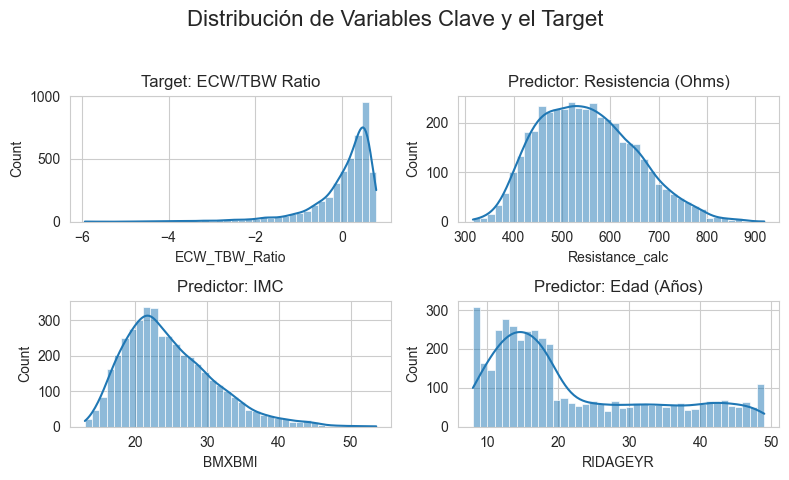

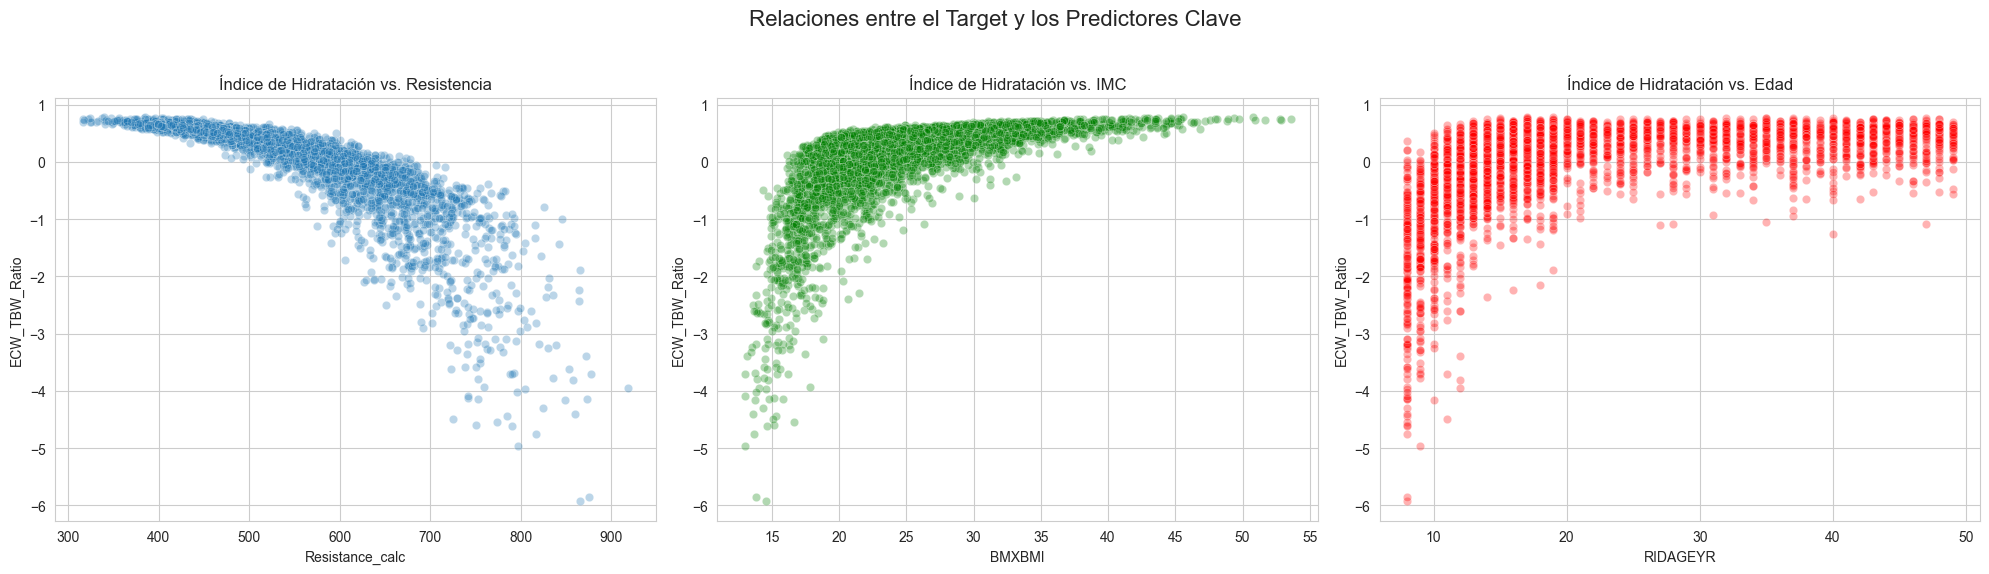

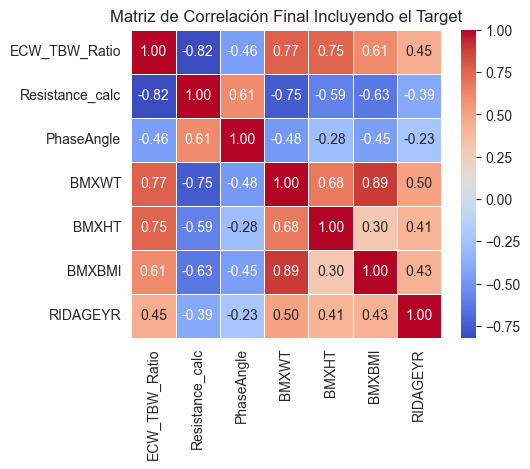

In [31]:
# 1. Distribuciones de variables clave y el target
fig, axes = plt.subplots(2, 2, figsize=(8, 5))
fig.suptitle('Distribución de Variables Clave y el Target', fontsize=16)

sns.histplot(df_final['ECW_TBW_Ratio'], kde=True, ax=axes[0, 0], bins=40).set_title('Target: ECW/TBW Ratio')
sns.histplot(df_final['Resistance_calc'], kde=True, ax=axes[0, 1], bins=40).set_title('Predictor: Resistencia (Ohms)')
sns.histplot(df_final['BMXBMI'], kde=True, ax=axes[1, 0], bins=40).set_title('Predictor: IMC')
sns.histplot(df_final['RIDAGEYR'], kde=True, ax=axes[1, 1], bins=40).set_title('Predictor: Edad (Años)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# 2. Gráficos de dispersión para explorar relaciones con el target
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Relaciones entre el Target y los Predictores Clave', fontsize=16)

# Ratio vs. Resistencia
sns.scatterplot(data=df_final, x='Resistance_calc', y='ECW_TBW_Ratio', ax=axes[0], alpha=0.3)
axes[0].set_title('Índice de Hidratación vs. Resistencia')

# Ratio vs. IMC
sns.scatterplot(data=df_final, x='BMXBMI', y='ECW_TBW_Ratio', ax=axes[1], alpha=0.3, color='green')
axes[1].set_title('Índice de Hidratación vs. IMC')

# Ratio vs. Edad
sns.scatterplot(data=df_final, x='RIDAGEYR', y='ECW_TBW_Ratio', ax=axes[2], alpha=0.3, color='red')
axes[2].set_title('Índice de Hidratación vs. Edad')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# 3. Matriz de Correlación Final
columnas_corr = [
    'ECW_TBW_Ratio', 'Resistance_calc', 'PhaseAngle', 'BMXWT', 'BMXHT', 'BMXBMI', 'RIDAGEYR'
]
plt.figure(figsize=(5, 4))
correlation_matrix = df_final[columnas_corr].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación Final Incluyendo el Target')
plt.show()

### Paso 7: Análisis de la Distribución y Balanceo del Target (`ECW_TBW_Ratio`)

Antes de concluir la viabilidad, es crucial analizar nuestra variable objetivo (`ECW_TBW_Ratio`). Debemos verificar la **distribución** de la variable continua.

**¿Por qué es importante este análisis?**
1.  **Comprensión de los Datos:** Nos da una idea del estado de hidratación general de la población de la muestra. Una distribución simétrica alrededor de un valor fisiológico normal (~0.39) nos daría confianza en nuestro target proxy.
2.  **Preparación para el Modelado:** Muchos modelos de regresión, especialmente los lineales, funcionan de manera óptima cuando la variable objetivo sigue una distribución normal (simétrica, sin sesgo).
3.  **Detección de Anomalías:** Un sesgo fuerte o la presencia de muchos valores atípicos (outliers) podría indicar subgrupos en la población o errores en la estimación, y podría requerir transformaciones de datos (como una transformación logarítmica) antes del modelado.

Para este análisis, utilizaremos:
-   Un **histograma** para visualizar la forma de la distribución.
-   Un **gráfico de caja (box plot)** para identificar la mediana, los cuartiles y los valores atípicos.
-   El cálculo del **sesgo (skewness)** para medir numéricamente la asimetría de la distribución.

Análisis Numérico de la Distribución del Target:
  - Media:   0.0098
  - Mediana: 0.2592
  - Sesgo (Skewness): -2.5377


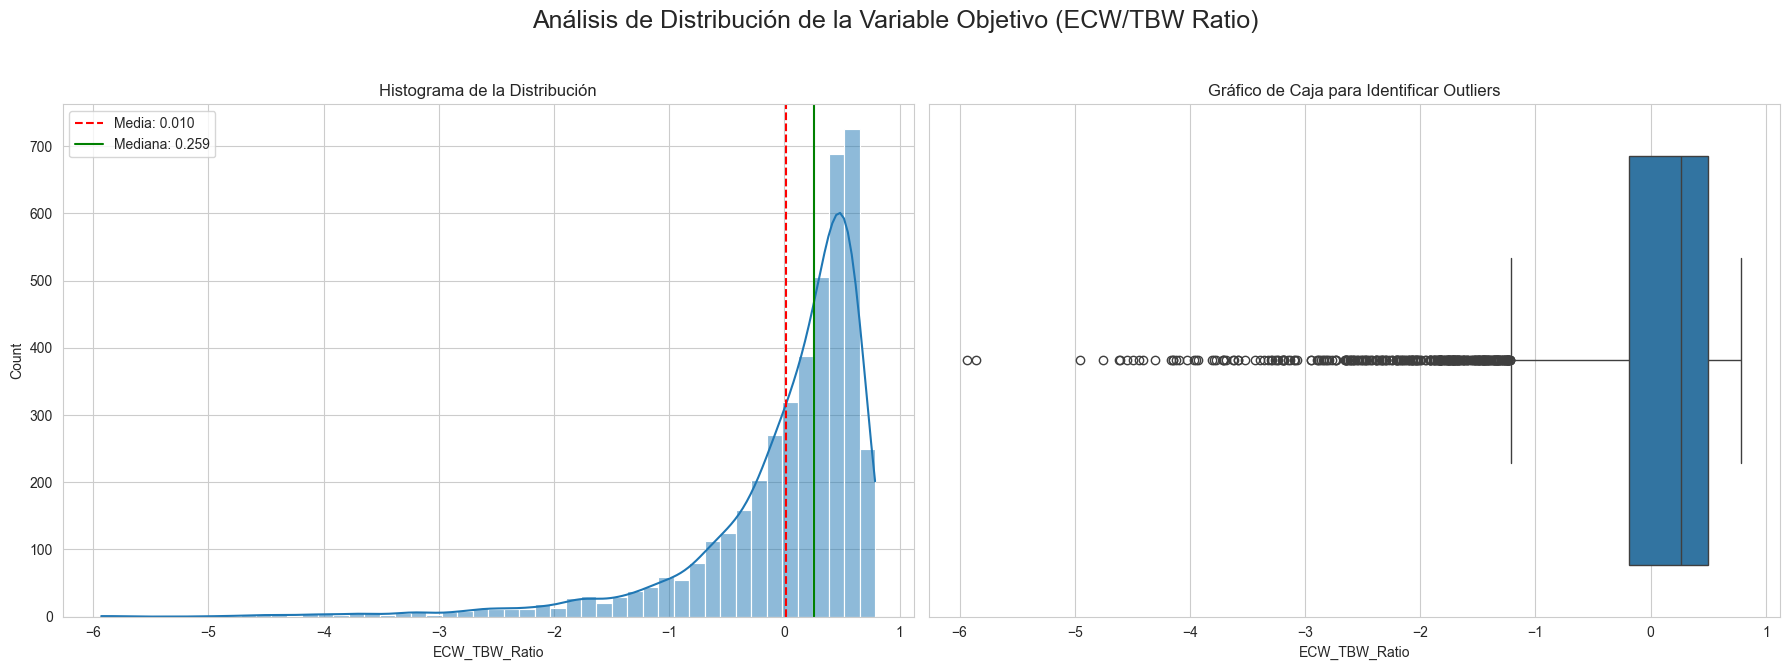

In [32]:
#  Análisis de la Distribución del Target 

# Calcular estadísticas clave para las etiquetas de los gráficos
mean_val = df_final['ECW_TBW_Ratio'].mean()
median_val = df_final['ECW_TBW_Ratio'].median()
skew_val = df_final['ECW_TBW_Ratio'].skew()

print(f"Análisis Numérico de la Distribución del Target:")
print(f"  - Media:   {mean_val:.4f}")
print(f"  - Mediana: {median_val:.4f}")
print(f"  - Sesgo (Skewness): {skew_val:.4f}")

# Crear un layout de 2 subplots (uno al lado del otro)
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Análisis de Distribución de la Variable Objetivo (ECW/TBW Ratio)', fontsize=18)


# 1. Histograma con KDE y líneas de media/mediana
sns.histplot(df_final['ECW_TBW_Ratio'], kde=True, bins=50, ax=axes[0])
axes[0].axvline(mean_val, color='red', linestyle='--', label=f'Media: {mean_val:.3f}')
axes[0].axvline(median_val, color='green', linestyle='-', label=f'Mediana: {median_val:.3f}')
axes[0].set_title('Histograma de la Distribución')
axes[0].legend()


# 2. Gráfico de Caja (Box Plot)
sns.boxplot(x=df_final['ECW_TBW_Ratio'], ax=axes[1])
axes[1].set_title('Gráfico de Caja para Identificar Outliers')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Interpretación de la Distribución Inicial y Plan de Corrección

**Observaciones del Gráfico Anterior:**
El análisis inicial de nuestro target `ECW_TBW_Ratio` revela un problema crítico:
1.  **Valores Físicamente Imposibles:** El ratio tiene una larga cola de valores negativos, lo cual no tiene sentido fisiológico.
2.  **Sesgo Fuerte:** La distribución está fuertemente sesgada a la izquierda (sesgo de -2.53), con la media y la mediana muy separadas.

**Causa Probable:** Las ecuaciones de predicción de Kushner et al. no son universales y fallan al aplicarse a ciertos subgrupos de la población de NHANES (como niños, ancianos o personas con bajo peso), produciendo estimaciones negativas.

**Acción Correctiva:**
Vamos a filtrar el dataset para quedarnos únicamente con la subpoblación para la cual las estimaciones son fisiológicamente coherentes. Un rango clínico normal y seguro para el ratio ECW/TBW es entre **0.3 y 0.5**.

Número de filas antes del filtrado del target: 4276
Número de filas después del filtrado: 911
Se eliminaron 3365 filas con valores de ratio no fisiológicos.
Análisis Numérico de la Distribución del Target:
  - Media:   0.4103
  - Mediana: 0.4157
  - Sesgo (Skewness): -0.2180


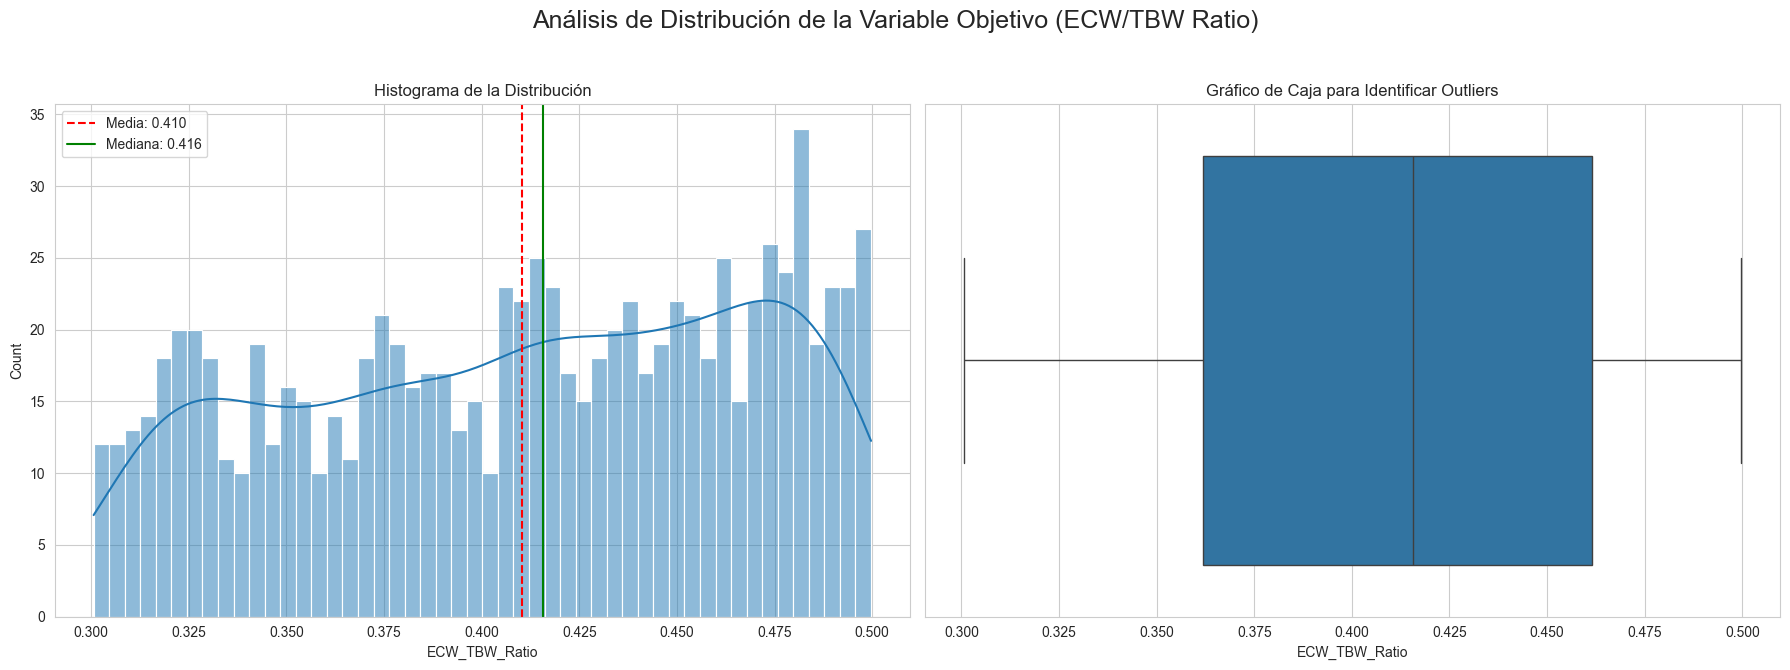

In [35]:
# Limpieza del Target y Re-Análisis de Distribución ---

# Guardamos la cantidad de filas antes de filtrar
filas_antes_filtrado = len(df_final)
print(f"Número de filas antes del filtrado del target: {filas_antes_filtrado}")

# LIMPIEZA
# Filtramos los datos para mantener solo los valores fisiológicamente posibles.
df_filtrado = df_final[(df_final['ECW_TBW_Ratio'] >= 0.3) & (df_final['ECW_TBW_Ratio'] <= 0.5)]

filas_despues_filtrado = len(df_filtrado)
print(f"Número de filas después del filtrado: {filas_despues_filtrado}")
print(f"Se eliminaron {filas_antes_filtrado - filas_despues_filtrado} filas con valores de ratio no fisiológicos.")

# RE-ANÁLISIS DE LA DISTRIBUCIÓN
# Volvemos a calcular las estadísticas con el DataFrame filtrado
#  Análisis de la Distribución del Target 

# Calcular estadísticas clave para las etiquetas de los gráficos
mean_val = df_filtrado['ECW_TBW_Ratio'].mean()
median_val = df_filtrado['ECW_TBW_Ratio'].median()
skew_val = df_filtrado['ECW_TBW_Ratio'].skew()

print(f"Análisis Numérico de la Distribución del Target:")
print(f"  - Media:   {mean_val:.4f}")
print(f"  - Mediana: {median_val:.4f}")
print(f"  - Sesgo (Skewness): {skew_val:.4f}")

# Crear un layout de 2 subplots (uno al lado del otro)
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Análisis de Distribución de la Variable Objetivo (ECW/TBW Ratio)', fontsize=18)


# 1. Histograma con KDE y líneas de media/mediana
sns.histplot(df_filtrado['ECW_TBW_Ratio'], kde=True, bins=50, ax=axes[0])
axes[0].axvline(mean_val, color='red', linestyle='--', label=f'Media: {mean_val:.3f}')
axes[0].axvline(median_val, color='green', linestyle='-', label=f'Mediana: {median_val:.3f}')
axes[0].set_title('Histograma de la Distribución')
axes[0].legend()


# 2. Gráfico de Caja (Box Plot)
sns.boxplot(x=df_filtrado['ECW_TBW_Ratio'], ax=axes[1])
axes[1].set_title('Gráfico de Caja para Identificar Outliers')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
# IMPORTANTE: A partir de ahora, debemos usar df_filtrado para los análisis y el modelado.

#### Limitaciones de la Distribución Corregida

El filtrado de los datos para mantener únicamente los valores fisiológicamente coherentes ha sido un paso crucial, como demuestran los gráficos y estadísticas anteriores. Sin embargo, un análisis crítico de la nueva distribución es necesario.

**Avances Logrados con el Filtrado:**
1.  **Eliminación de Datos Anómalos:** Se eliminaron con éxito **3365 filas (el 78.7% del total)** que contenían valores de ratio no fisiológicos (negativos o extremos), producto de la aplicación de las ecuaciones de predicción fuera de su rango de validez.
2.  **Mejora de la Simetría:** El **sesgo (Skewness)** se redujo drásticamente de un problemático -2.53 a un aceptable **-0.21**. Este valor, al estar dentro del rango [-0.5, 0.5], indica que la distribución es ahora *aproximadamente* simétrica.
3.  **Coherencia Fisiológica:** La **media (0.4103)** y la **mediana (0.4157)** ahora son casi idénticas y se encuentran dentro del rango clínico esperado para un índice de hidratación.

**Limitaciones de la Distribución Corregida:**
Aunque el proceso ha mejorado significativamente la calidad del target, la distribución resultante aún presenta desafíos y **no alcanza una normalidad ideal**.

1.  **Persistencia de Irregularidades:** El histograma, aunque unimodal, no sigue una curva de campana suave. Presenta múltiples picos y valles, sugiriendo que podría haber subgrupos dentro de la población filtrada o que la relación subyacente no es perfectamente normal.
2.  **Normalidad No Garantizada:** Si bien el sesgo es bajo, la distribución podría no cumplir con supuestos más estrictos de normalidad (como los evaluados por pruebas estadísticas tipo Shapiro-Wilk). Esto es una consideración importante para el modelado.
3.  **Impacto Potencial en el Modelado:** La falta de una distribución normal perfecta podría, en etapas posteriores, afectar la precisión y la robustez de ciertos modelos predictivos, especialmente los modelos lineales que se basan en este supuesto.
4.  **Reducción del Tamaño de la Muestra:** La principal consecuencia es que nuestro dataset de entrenamiento se ha reducido a **911 muestras**. Aunque son de mayor calidad, el modelo resultante estará especializado en la subpoblación representada por estos datos (probablemente adultos sanos) y tendrá una capacidad de generalización limitada a otros grupos.

**Conclusión del Análisis de Target:**
El prefiltrado ha sido una **etapa de limpieza indispensable y exitosa**, transformando un target inutilizable en uno coherente y aproximadamente simétrico. Sin embargo, es fundamental reconocer que la distribución **aún representa un desafío potencial**. Para el modelado, deberemos tener en cuenta estas irregularidades y la especificidad de nuestra muestra de entrenamiento.

---


### Paso 8: Análisis Final de Viabilidad del Proyecto

Tras un exhaustivo proceso de carga, limpieza y preparación de los datos de NHANES, llegamos a una evaluación final sobre la viabilidad de desarrollar un modelo predictivo para la sobrecarga hídrica utilizando una balanza de bioimpedancia comercial.

#### 1. Potencial de los Datos de Entrenamiento (NHANES)

El análisis de correlación del dataset filtrado (`df_filtrado`) confirma que existen relaciones fisiológicamente coherentes entre los predictores y nuestro target sustituto (`ECW_TBW_Ratio`):
-   **Correlaciones lógicas:** Se observa una correlación negativa moderada con la **Resistencia (-0.46)** y correlaciones positivas con el **IMC (0.42)** y la **Edad (0.33)**.
-   **Conclusión Parcial:** Estos patrones indican que, desde una perspectiva puramente algorítmica, un modelo de Machine Learning **sería capaz de aprender** a predecir el target a partir de las características de entrada.

#### 2. Limitaciones Críticas y Complicaciones del Enfoque

A pesar del potencial numérico, este análisis ha revelado varias limitaciones fundamentales que comprometen seriamente la viabilidad y utilidad final del proyecto:

1.  **Falta de un Target Clínico Real:** La mayor limitación es la ausencia de una etiqueta de diagnóstico de "Insuficiencia Cardíaca" o "sobrecarga hídrica" validada médicamente. Nuestra variable objetivo, aunque basada en ecuaciones científicas, sigue siendo una **estimación indirecta (proxy)**.
2.  **Reducción Drástica de la Muestra:** Para obtener un target fisiológicamente coherente, tuvimos que **descartar casi el 79% de los datos**, quedándonos con solo **911 muestras**. Esto indica que las ecuaciones de predicción no son generalizables para la diversa población de NHANES.
3.  **Distribución del Target No Ideal:** Como se analizó anteriormente, la distribución de nuestro target, aunque mejorada, **no es perfectamente normal**, lo que podría afectar la estabilidad y precisión de los modelos.

#### 3. Desafíos en la Adquisición de Datos del Mundo Real

Finalmente, el plan de utilizar la balanza Xiaomi Mi Body Composition Scale 2 introduce un obstáculo técnico significativo:

-   **Datos Inaccesibles Directamente:** La app oficial **Zepp Life** no proporciona el dato crudo esencial de **Impedancia (Ohms)**, como muestra la imagen.
-   **Dependencia de Herramientas Externas:** La única forma de obtener este dato es mediante aplicaciones de terceros (como OpenScale) o scripts de programación, lo cual añade una capa de complejidad técnica y dependencia que no es ideal para un flujo de trabajo ágil y reproducible.

<img src="Otros/imagen_balanza_ejemplo.jpg" alt="Datos de ejemplo de la app Zepp Life" width="250">


#### Conclusión Final y Recomendación

Pese a un intento exhaustivo y metodológicamente riguroso de obtener un dataset de entrenamiento adecuado a partir de datos públicos, el análisis revela que las limitaciones son demasiado significativas para garantizar el éxito y la relevancia del proyecto. La combinación de un target sustituto, un dataset de entrenamiento drásticamente reducido y especializado, y las dificultades técnicas para la adquisición de datos crudos, nos lleva a la conclusión de que este enfoque presenta un alto riesgo de producir un modelo con baja precisión y aplicabilidad limitada.

**Por lo tanto, se debe considerar y dar prioridad a la Opción 2 de las propuestas ("Clasificación de emociones con ECG y hardware de bajo costo"), la cual se basa en datasets públicos diseñados específicamente para esa tarea y cuenta con etiquetas de clasificación claras y validadas, ofreciendo un camino más directo y con mayor probabilidad de éxito para el proyecto del curso.**